20180634_최준혁_project

In [1]:
# 한글 폰트 설정
import matplotlib.font_manager as fm
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
%%writefile class_standby.py
import random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

'''GYM class의 oneday에 쓰이는 메소드들'''        
def make_empty_df(self): #빈 data_frame생성
    #dataframe만들기 위한 index, columns
    ind = list(self.machine.keys()) ; ind.insert(0,'visiter') #index: 방문자정보와 기구정보
    col = list(range(self.open_t,self.close_t)) #colums: 각 시간
        
    #dataframe만들고 빈 리스트들로 초기화 
    #방문자행은 각 칸에 [방문자들 리스트]
    #기구 정보행은 [[기구수],[기구원하는사람들],[실제사용한사람들],[사용못한사람들]]
    L1 = list()
    for j in range(len(ind)) :
        L2 = list()
        for i in range(len(col)) : 
            L3 = list() ; L2.append(L3)
        L1.append(L2)
    df = pd.DataFrame(L1, columns= col, index = ind) #먼저 모든 원소를 []로 초기화
    for machine in self.machine.keys():
        for t in range(self.open_t,self.close_t):
            want = list(); can =list(); cant = list()
            append = [self.machine[machine],want, can, cant] # [[],[],[],[]]로 초기화
            for k in append: df.loc[machine][t].append(k)
    return df          

def check_unregisters(self): #30일 운동 이후 만족도 60%보다 낮으면 탈퇴하도록 설정   
    for person in self.customer:
        if person.gym_day_count >=30 and person.cum_satisf[0]/person.cum_satisf[1] < 0.6:
            person.gym_day_count = 0
            self.unregister.append(person)
            self.customer.remove(person)
            print('\t{} 님이 영업 {}일차에 탈퇴하셨습니다.'.format(person.name, self.duration))
            
def fill_the_df(self, df): #하루 운영하면서 빈 data_frame에 data들을 채움
    for t in range(self.open_t,self.close_t):
        using_at_t = list()
        for person in self.customer:
            if person.time == t and \
            person.routine[person.routine_count%len(person.routine)] != ['rest']: 
                df.loc['visiter'][t].append(person) #방문자행에 시간대에 맞게 방문자 추가
                for machine in person.routine[person.routine_count%len(person.routine)]:
                    df.loc[machine][t][1].append(person) #원하는 운동기구에 자신의 이름 추가 
                person.gym_day_count += 1 #그 사람의 현재 체육관 운동일 수 증가
            person.routine_count += 1 #그 사람의 루틴일 수 증가
            person.exp += 1 #운동 경력일 수 1일 증가
                
        for machine in self.machine.keys():
            shortage = len(df.loc[machine][t][1]) - df.loc[machine][t][0]*3 
            if shortage > 0:  #운동기구 부족한 정도를 파악, 부족하면 못하는 사람은 랜덤하게 선정 
                df.loc[machine][t][3] = random.sample(df.loc[machine][t][1],shortage)
                for person in df.loc[machine][t][3]:
                    person.cum_satisf += np.array([0,1]) #운동 못했으면 만족도에 0,1추가
                    person.fail[machine]+=1 #fail사전에도 못한 운동 기구의 횟수 증가
                    
                for person in df.loc[machine][t][1]:#기구 부족했지만 운좋게 자리잡고 운동한 사람
                    if person in df.loc[machine][t][3] : continue
                    else : 
                        df.loc[machine][t][2].append(person) 
                        person.cum_satisf += np.array([1,1]) 
            else : #기구 안부족해서 모두 이용
                df.loc[machine][t][2] = df.loc[machine][t][1]
                for person in df.loc[machine][t][2]: person.cum_satisf += np.array([1,1])
            
            #check unregisters : 30일 운동 이후 만족도 60%보다 낮으면 탈퇴하도록 설정
            check_unregisters(self)
    return df
    
    
'''클래스 정의'''
class Person:
    def __init__(self, name, expday, gender, time, routine): 
        self.name = name #이름
        self.exp = expday #운동경력 일수
        self.gender = gender #성별
        self.routine = routine #운동 루틴
        self.time = time #하루 중 운동 시작하는 시간
        self.routine_count = 0 #휴식을 포함한 루틴일수 체크
        self.gym_day_count = 0 #휴식을 미포함한 지금 운동하는 체육관에서 운동한 날수 체크
        self.cum_satisf = np.array([0,0]) #누적 만족도 [실제 사용한 횟수, 사용하고자 한 횟수]
        self.fail = dict() #key = 사용못한 기구들, value = 사용못한 횟수 
        
        for day_routine in self.routine: #fail사전 초기화(루틴에 필요한 기구들을 key로 넣고 0초기화)
            if day_routine == ['rest'] : continue 
            for machine in day_routine: self.fail[machine] = 0
    
class Gym:
    def __init__(self, machine):
        self.customer = [] ; self.unregister = [] #고객들 명단, 탈퇴 회원 명단
        self.machine = machine #기구 사전들 key = 기구, value = 해당기구 수
        self.open_t = 6 ; self.close_t = 23 #영업시간
        self.duration = 0 #영업일
        self.gym_data = list() #매일매일 체육관 운영data를 append
        
    def regist(self, person): #회원 등록
        person.gym_day_count = 0
        self.customer.append(person)
        self.customer = sorted(self.customer, key = lambda per: per.time) #운동 시간 순 정렬
        
    def oneday(self): #체육관 하루 운영 메소드
        df = make_empty_df(self) #빈 data_frame생성
        df = fill_the_df(self, df) #하루 운영하면서 빈 data_frame에 data들을 채움
        self.duration += 1 #하루가 지나면 영업일수 증가
        self.gym_data.append(df) #하루의 data를 담은 dataframe을 gym_data에 append

    def business_days(self, n):  # N일 운영하는 메소드 
        print('\n@체육관을 {}일 운영하고 데이터처리를 합니다@'.format(n))
        for i in range(n):
            self.oneday()

Overwriting class_standby.py


In [3]:
from class_standby import*
import random
import re 

#data_loading에 쓰이는 메소드(루틴 추천)
def recommend_routine(Gym,name, exp, gender,printf = True):
    sort_customer = sorted(Gym.customer, key = lambda x: x.exp)
    same_gender_sort = list() ; similar = list()
    for person in sort_customer: 
        if person.gender == gender[0] : same_gender_sort.append(person)

    nearest = dict()
    for i in range(len(same_gender_sort)):
        nearest[i] = abs(same_gender_sort[i].exp-int(exp[0]))
    nearest = sorted(nearest.items(), key = lambda x:x[1])
            
    similar = list()
    for i in range(10):
        similar.append(same_gender_sort[nearest[i][0]])
    sim = random.choice(similar) #간단하게 랜덤으로 추천해주었으나 보완이 필요한 부분
    if printf == True:
        print('  {}님은 루틴을 입력하지 않으셨으므로 경력과 성별에 맞게 추천드렸습니다'.format(name[0]))
        print('-> 추천루틴 : ',sim.routine)
    return sim.routine

#FILE에서 회원 데이터 가져오기
def data_loading(Gym, printf = True): 
    print('@파일에서 회원데이터를 불러와 체육관에 등록합니다.@')
    fp = open("customer1.txt","rt",encoding= "cp949")
    for line in fp.readlines():
        name = re.search('(?<=이름: )\w*(?=,)', line)
        exp = re.search('(?<=경력\(일\): )\d*(?=,)', line)
        gender = re.search('(?<=성별: )\w*(?=,)', line)
        time = re.search('(?<=운동시작시간: )\d*(?=,)', line)
        routine = re.search('(?<=루틴: ).*(?=/)', line)
        pass_flag = False

        try : #루틴이 없을 경우 예외처리 이용하여 루틴 추천해줌
            day_routine = (routine[0]).split('/') ; routine_list = list()
        except:
            routine_list = recommend_routine(Gym,name,exp,gender,printf)
            person = Person(name[0], int(exp[0]), gender[0], int(time[0]), routine_list)
            pass_flag = True

        if pass_flag == False:
            for i in day_routine:
                temp = list()
                spt = i.split(',')
                for j in spt:
                    temp.append(j)
                routine_list.append(temp)
            person = Person(name[0], int(exp[0]), gender[0], int(time[0]), routine_list)
        Gym.regist(person)
    fp.close()

In [4]:
#ANALYZE FUNCTIONS ; 분석tool 
# 구현하고자하는 바는 맨 아래 결과창 확인

#시간대별 일 평균 방문자 수 분석
def visiter_at_t(gym_data, plot = True): 
    visit_data = dict()
    for df in gym_data:
        for t in df.loc['visiter'].index:
            visit_data[t] = 0
    for df in gym_data:
        for t in df.loc['visiter'].index:
            visit_data[t] += len(df.loc['visiter'][t])
    for i in visit_data:
        visit_data[i] = round(visit_data[i]/len(gym_data),2)
    sort_high = dict(sorted(visit_data.items(), key = lambda x: x[1],reverse= True))
    sort_low = dict(sorted(visit_data.items(), key = lambda x: x[1])) ; low = list()
    
    if plot == True:
        plt.figure(figsize=(7,4))
        plt.title('시간대별 평균 이용자 수')
        X = list(visit_data.keys())
        Y = list(visit_data.values())
        plt.xlabel("시간대") ; plt.ylabel("평균 이용자 수")
        plt.xticks(list(visit_data.keys()))
        plt.plot(X,Y)
        plt.show()
    
    print('\n\n방문자가 가장 많은 시간대 top 5: ', end = "") ; cnt = 0
    for i in sort_high:
        print('{}시'.format(i), end= " ") ; cnt += 1 
        if cnt == 5: break
    print('\n방문자가 가장 적은 시간대 top 5: ', end = "") ; cnt = 0
    for i in sort_low:
        print('{}시'.format(i), end= " ") ; cnt += 1 
        low.append(i)
        if cnt == 5: break
    print()
    low = sorted(low)
    for i in low:
        print(" "+ str(i)+'~'+str(i+1)+'시', end = "")
    print('에 이용하는 회원이 적으므로 이 시간대에만 운동할 수 있는 회원권을 \
할인된 가격으로 출시하면 매출 상승에 도움이 될 것입니다')
    

#운동기구 별 경쟁률(기구 사용할 수 있는 양 대비 사용하고자하는 양) 분석   
def machine_rate(gym_data, plot = True,printf = True):
    rate_data = dict()
    for df in gym_data:
        for machine in df.index[1::]: rate_data[machine] = np.array([0,0])
    for df in gym_data:
        for machine in df.index[1::]: 
            for t in df.columns:
                rate_data[machine] += np.array([len(df.loc[machine][t][1]),\
                                                df.loc[machine][t][0]*3])
    for i in rate_data:
        rate_data[i] = round(rate_data[i][0]/rate_data[i][1],4)*100
    
    if plot == True:
        plt.figure(figsize=(7,4))
        plt.title('기구별 경쟁률 현황')
        X = ['BP','CF','CP','Dp','LFD','DL','Row','PU','TB','Sq','LP','LE','LC','DB',\
         'BB','Cb','Sm','TM','CC']
        Y = list(rate_data.values())
        plt.ylabel("기구 경쟁률(%)") ; plt.xlabel("기구들")
        plt.bar(X,Y)
        plt.show()
    
    low = list()
    if printf == True:
        sort_high = dict(sorted(rate_data.items(), key = lambda x: x[1],reverse= True))
        sort_low = dict(sorted(rate_data.items(), key = lambda x: x[1]))
        
        print('<기구 경쟁률: 기구 사용할 수 있는 양 대비 사용하고자하는 양>')
        print('\n기구 경쟁률 높은 top 5: ', end = "") ; cnt = 0
        for i in sort_high:
            print('{}'.format(i), end= " ") ; cnt += 1 
            if cnt == 5: break
        print('\n기구 경쟁률 낮은 top 5: ', end = "") ; cnt = 0
        for i in sort_low:
            print('{}'.format(i), end= " ") ; cnt += 1 
            low.append(i)
            if cnt == 5: break
        print()
        for i in low:
            print(" "+i, end = "")
        print('는 기구 경쟁률이 낮은 기구들이므로 기구의 개수가 2대 이상일 경우 1대씩 판매하여 감축하는 것이 좋아보입니다')
    return low, rate_data


# 탈퇴 회원들의 탈퇴원인 기구들 분석(사용하고 싶었지만 자리가 없어서 사용하지 못한 기구들)
def fail_analyze(Gym, plot = True, printf = True):
    fail_dict = dict()
    for key in list(Gym.machine.keys()):
        fail_dict[key] = 0
    
    for person in Gym.unregister:
        for key in person.fail.keys():
            fail_dict[key] += person.fail[key]
            
    if plot == True:
        plt.figure(figsize=(7,4))
        plt.title('탈퇴한 회원들이 사용하지 못한 기구들과 그 횟수 총합')
        X = ['BP','CF','CP','Dp','LFD','DL','Row','PU','TB','Sq','LP','LE','LC','DB',\
         'BB','Cb','Sm','TM','CC']
        Y = list(fail_dict.values())
        plt.xlabel("기구들") ; plt.ylabel("사용못한 누적 횟수")
        plt.bar(X,Y)
        plt.show()
            
    high = list()
    if printf == True:    
        sort_high = dict(sorted(fail_dict.items(), key = lambda x: x[1],reverse= True))
        print('<수요대비 부족했던 기구들(탈퇴 원인) : 사용하고 싶었지만 자리가 없어서 사용하지 못한 기구들>')
        print('\n탈퇴 이유(기구) top 5: ', end = "") ; cnt = 0
        for i in sort_high:
            print('{}'.format(i), end= " ") ; cnt += 1 
            high.append(i)
            if cnt == 5: break
        print('\n위 기구들은 수요대비 공급이 부족하여 회원들의 만족도를 감소시켜 탈퇴를 유발한 기구들이므로 \
최소 1대씩 추가하는 것이 회원유지(탈퇴방지)에 도움이 될 것입니다') 
    return high, fail_dict

#두 체육관 비교 분석
def gym_compare_analyze(G1, G2):
    fail_dict1 = fail_analyze(G1, False, False)[1] 
    fail_dict2 = fail_analyze(G2, False, False)[1]
    rate_data1 = machine_rate(G1.gym_data, False, False)[1] 
    rate_data2 = machine_rate(G2.gym_data, False, False)[1]
    
    plt.figure(figsize=(7,4))
    plt.title('기구별 경쟁률 현황')
    X = ['BP','CF','CP','Dp','LFD','DL','Row','PU','TB','Sq','LP','LE','LC','DB',\
         'BB','Cb','Sm','TM','CC']
    Y1 = list(rate_data1.values())
    Y2 = list(rate_data2.values())
    Y3 = list() 
    for i in range(len(X)): Y3.append(33.33)
            
    plt.ylabel("기구 경쟁률(%)") ; plt.xlabel("기구들")
    plt.plot(X,Y1,label = 'G1')
    plt.plot(X,Y2,label = 'G2')
    plt.plot(X,Y3,label = '적정 수준', color = 'r', ls = '--')
    plt.legend(loc = 0)
    plt.show()
    print('기구 경쟁률은 너무 높으면 사용하지 못하는 사람이 많아지고 너무 낮으면 \
사용하는 사람이 없으므로 가동률이 낮아집니다.') 
    print('그러므로 적정 수준인(1시간에 기구 1대를 3명이 사용할 수 있으므로) 33%에 가까울 수록 좋습니다')
    
    plt.figure(figsize=(7,4))
    plt.title('탈퇴한 회원들이 사용하지 못한 기구들과 그 횟수 총합')
    X = ['BP','CF','CP','Dp','LFD','DL','Row','PU','TB','Sq','LP','LE','LC','DB',\
        'BB','Cb','Sm','TM','CC']
    Y1 = list(fail_dict1.values())
    Y2 = list(fail_dict2.values())
    plt.xlabel("기구들") ; plt.ylabel("사용못한 누적 횟수")
    plt.plot(X,Y1,label = 'G1')
    plt.plot(X,Y2,label = 'G2')
    plt.legend(loc = 0)
    plt.show()
    
    print('G1의 탈퇴회원명단: ', end = ' ')
    for i in G1.unregister: print(i.name, end = " ")
    print('\nG2의 탈퇴회원명단: ', end = ' ')
    for i in G2.unregister: print(i.name, end = " ")
    
    if len(G1.unregister) > len(G2.unregister) :
        print('\n\nG2가 더 적게 탈퇴하였으므로 G2가 고객만족도가 높습니다')
        print('G1 >>> G2로의 업그레이드가 성공적입니다')
    else : 
        print('\n\nG1이 더 적게 탈퇴하였으므로 G1이 고객만족도가 높습니다')
        print('G1 >>> G2로의 업그레이드가 실패적입니다')

In [5]:
from class_standby import*
import time 
import copy
%matplotlib notebook

# MAIN 파트
def Simulating():
    machine = {'BenchPress':2, 'ChestFly' :1, 'ChestPress':1, 'Dips' : 2,\
            'LetFullDown':1, 'DeadLift' : 1, 'Row' : 1, 'PullUp' : 2, 'TBar':2,\
            'Squat' : 2,  'LegPress':1, 'LegExtension':1, 'LegCurl':2,\
            'DumbBell' : 2, 'BarBell': 2, 'Cable' : 2, 'Smith' : 1,\
            'TreadMill': 2, 'Cycle' : 2}
    print('<G1을 시뮬레이팅합니다>\n')
    G1 = Gym(machine)
    data_loading(G1)
    G1.business_days(50)
    visiter_at_t(G1.gym_data)
    low = machine_rate(G1.gym_data)
    high = fail_analyze(G1)
    print("-------------------------------------------------------------------")
    print('\n\n<G1에서 개선된 G2를 도입하여 G1, G2를 각각 시뮬레이팅한 후 비교합니다>')
    G1 = Gym(machine)

    machine1 = copy.deepcopy(machine)
    for i in low[0]: 
        if machine1[i] > 1: machine1[i]-=1
    for j in high[0]: machine1[j] += 1

    G2 = Gym(machine1)
    print("\n<G1>") ; data_loading(G1, printf = False)
    G1.business_days(50)
    print("\n<G2>") ; data_loading(G2, printf = False)
    G2.business_days(50)
    print() 
    gym_compare_analyze(G1, G2)
    
def check_time(func):
    def new_func():
        start_time = time.time()
        func()
        end_time = time.time()
        print("\n실행시간은: {}".format(end_time - start_time))
    return new_func

<G1을 시뮬레이팅합니다>

@파일에서 회원데이터를 불러와 체육관에 등록합니다.@
  김철수님은 루틴을 입력하지 않으셨으므로 경력과 성별에 맞게 추천드렸습니다
-> 추천루틴 :  [['BenchPress', 'LetFullDown', 'Smith', 'Squat', 'Cycle', 'DumbBell'], ['BenchPress', 'Smith', 'BarBell', 'LetFullDown', 'DeadLift', 'Squat', 'DumbBell'], ['BenchPress', 'LetFullDown', 'Squat', 'DumbBell'], ['rest']]
  김영희님은 루틴을 입력하지 않으셨으므로 경력과 성별에 맞게 추천드렸습니다
-> 추천루틴 :  [['BenchPress', 'ChestFly', 'LetFullDown', 'Row', 'TreadMill'], ['Squat', 'DeadLift', 'DumbBell', 'LegExtension', 'LegCurl', 'TreadMill', 'Cycle'], ['rest']]

@체육관을 50일 운영하고 데이터처리를 합니다@
	설태리 님이 영업 29일차에 탈퇴하셨습니다.
	강지윤 님이 영업 30일차에 탈퇴하셨습니다.
	이찬혁 님이 영업 39일차에 탈퇴하셨습니다.
	이재근 님이 영업 39일차에 탈퇴하셨습니다.
	김민중 님이 영업 39일차에 탈퇴하셨습니다.
	박지민 님이 영업 39일차에 탈퇴하셨습니다.
	박승철 님이 영업 39일차에 탈퇴하셨습니다.
	박서아 님이 영업 39일차에 탈퇴하셨습니다.
	김도연 님이 영업 39일차에 탈퇴하셨습니다.
	민방위 님이 영업 39일차에 탈퇴하셨습니다.
	원종한 님이 영업 43일차에 탈퇴하셨습니다.
	소병완 님이 영업 43일차에 탈퇴하셨습니다.
	강혁중 님이 영업 43일차에 탈퇴하셨습니다.
	박주은 님이 영업 43일차에 탈퇴하셨습니다.
	이용 님이 영업 43일차에 탈퇴하셨습니다.
	김영희 님이 영업 43일차에 탈퇴하셨습니다.


<IPython.core.display.Javascript object>


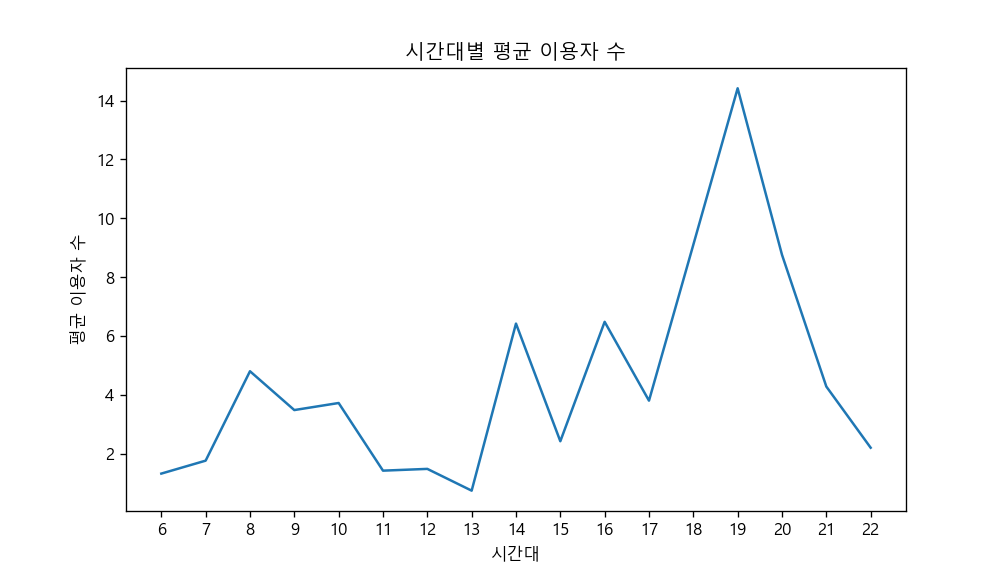



방문자가 가장 많은 시간대 top 5: 19시 18시 20시 16시 14시 
방문자가 가장 적은 시간대 top 5: 13시 6시 11시 12시 7시 
 6~7시 7~8시 11~12시 12~13시 13~14시에 이용하는 회원이 적으므로 이 시간대에만 운동할 수 있는 회원권을 할인된 가격으로 출시하면 매출 상승에 도움이 될 것입니다


<IPython.core.display.Javascript object>


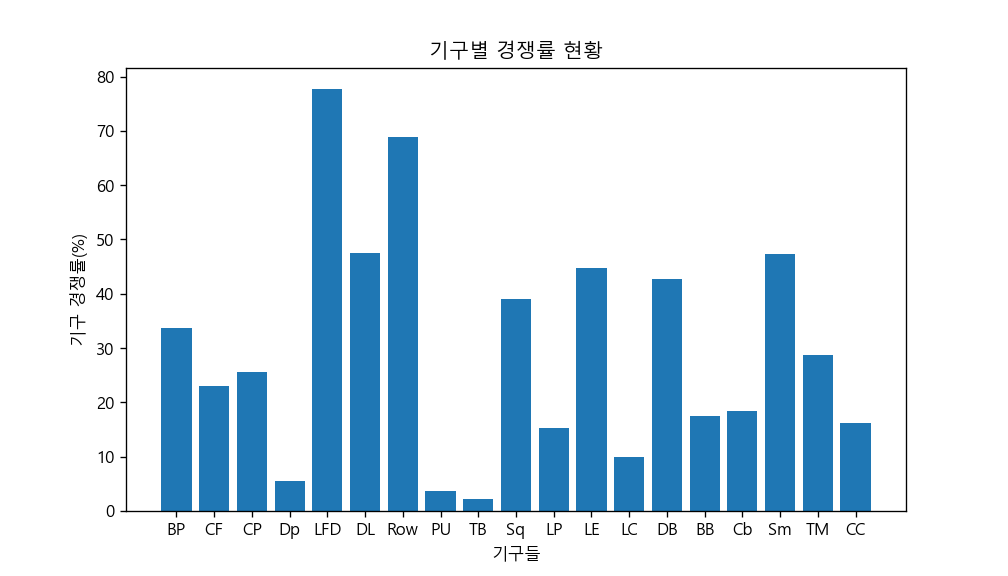

<기구 경쟁률: 기구 사용할 수 있는 양 대비 사용하고자하는 양>

기구 경쟁률 높은 top 5: LetFullDown Row DeadLift Smith LegExtension 
기구 경쟁률 낮은 top 5: TBar PullUp Dips LegCurl LegPress 
 TBar PullUp Dips LegCurl LegPress는 기구 경쟁률이 낮은 기구들이므로 기구의 개수가 2대 이상일 경우 1대씩 판매하여 감축하는 것이 좋아보입니다


<IPython.core.display.Javascript object>


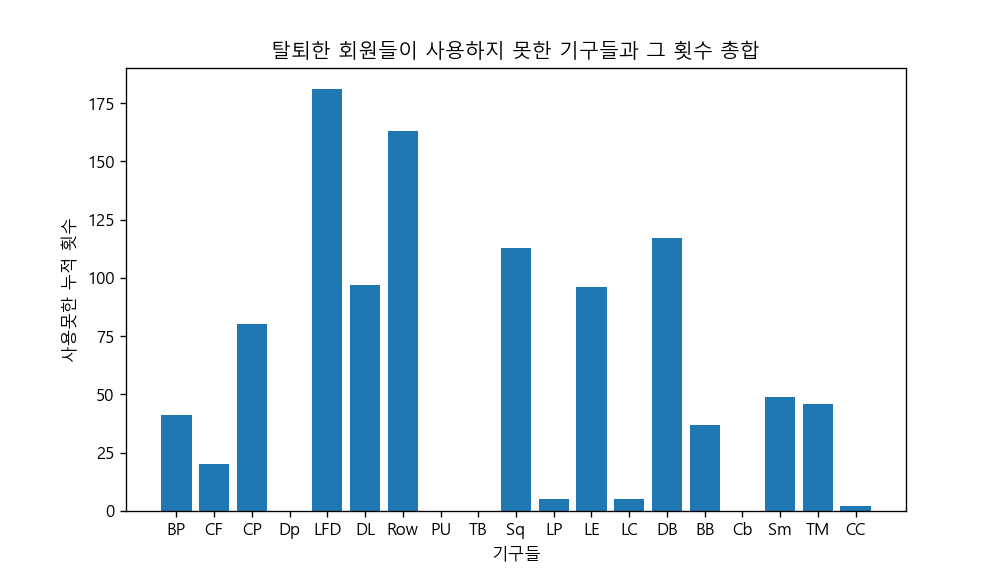

<수요대비 부족했던 기구들(탈퇴 원인) : 사용하고 싶었지만 자리가 없어서 사용하지 못한 기구들>

탈퇴 이유(기구) top 5: LetFullDown Row DumbBell Squat DeadLift 
위 기구들은 수요대비 공급이 부족하여 회원들의 만족도를 감소시켜 탈퇴를 유발한 기구들이므로 최소 1대씩 추가하는 것이 회원유지(탈퇴방지)에 도움이 될 것입니다
-------------------------------------------------------------------


<G1에서 개선된 G2를 도입하여 G1, G2를 각각 시뮬레이팅한 후 비교합니다>

<G1>
@파일에서 회원데이터를 불러와 체육관에 등록합니다.@

@체육관을 50일 운영하고 데이터처리를 합니다@
	이찬혁 님이 영업 39일차에 탈퇴하셨습니다.
	오시현 님이 영업 39일차에 탈퇴하셨습니다.
	이재근 님이 영업 39일차에 탈퇴하셨습니다.
	김민중 님이 영업 39일차에 탈퇴하셨습니다.
	박지민 님이 영업 39일차에 탈퇴하셨습니다.
	박승철 님이 영업 39일차에 탈퇴하셨습니다.
	박서아 님이 영업 39일차에 탈퇴하셨습니다.
	김도연 님이 영업 39일차에 탈퇴하셨습니다.
	민방위 님이 영업 39일차에 탈퇴하셨습니다.
	장동민 님이 영업 43일차에 탈퇴하셨습니다.
	소병완 님이 영업 43일차에 탈퇴하셨습니다.
	강혁중 님이 영업 43일차에 탈퇴하셨습니다.
	이용 님이 영업 43일차에 탈퇴하셨습니다.

<G2>
@파일에서 회원데이터를 불러와 체육관에 등록합니다.@

@체육관을 50일 운영하고 데이터처리를 합니다@
	이찬혁 님이 영업 39일차에 탈퇴하셨습니다.
	이재근 님이 영업 39일차에 탈퇴하셨습니다.
	김민중 님이 영업 39일차에 탈퇴하셨습니다.
	박지민 님이 영업 39일차에 탈퇴하셨습니다.
	박승철 님이 영업 39일차에 탈퇴하셨습니다.
	김영희 님이 영업 39일차에 탈퇴하셨습니다.
	박서아 님이 영업 39일차에 탈퇴하셨습니다.
	김도연 님이 영업 39일차에 탈퇴하셨습니다.
	민방위 님이 

<IPython.core.display.Javascript object>


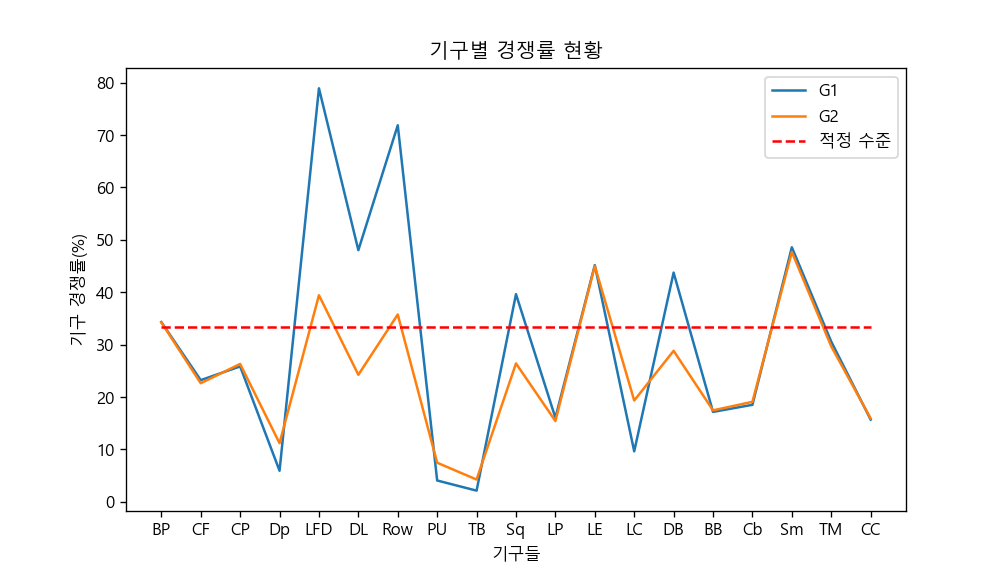

기구 경쟁률은 너무 높으면 사용하지 못하는 사람이 많아지고 너무 낮으면 사용하는 사람이 없으므로 가동률이 낮아집니다.
그러므로 적정 수준인(1시간에 기구 1대를 3명이 사용할 수 있으므로) 33%에 가까울 수록 좋습니다


<IPython.core.display.Javascript object>


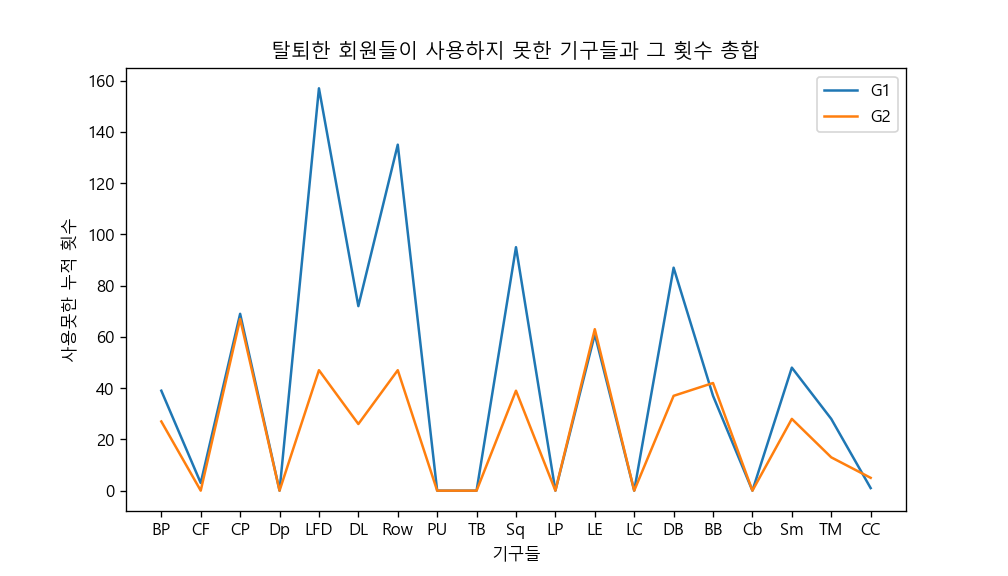

G1의 탈퇴회원명단:  이찬혁 오시현 이재근 김민중 박지민 박승철 박서아 김도연 민방위 장동민 소병완 강혁중 이용 
G2의 탈퇴회원명단:  이찬혁 이재근 김민중 박지민 박승철 김영희 박서아 김도연 민방위 

G2가 더 적게 탈퇴하였으므로 G2가 고객만족도가 높습니다
G1 >>> G2로의 업그레이드가 성공적입니다

실행시간은: 41.926175117492676


In [6]:
Gym_Simulating = check_time(Simulating)
Gym_Simulating()